<a href="https://colab.research.google.com/github/BenjaminJamesDay/lupi-ndp/blob/main/LUPI_NDP_for_damped_coupled_oscillators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchdiffeq

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchdiffeq import odeint
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import numpy as np

import random

import warnings

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    !nvidia-smi
else:
    device = torch.device("cpu")
    warnings.warn('GPU not attached')

Tue Feb  9 14:10:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    29W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dampled coupled oscillators
The `OscillatorsDataset` produces trajectory samples from a system of damped coupled oscillators. A pair of point masses are connected by springs between opposing walls in the chain: wall-spring-mass-spring-mass-spring-wall.

`|--o--o--|`

The equations of motion are

$$
m_1\ddot{x_1} = k\cdot(x_2 - 2x_1) - c\dot{x_1} \\
m_2\ddot{x_2} = k\cdot(x_1 - 2x_2) - c\dot{x_2}
$$

where $m_i$ is the mass of the $i$-th mass, $x_i$ is the displacement of the $i$-th mass from the equilibrium position, $k$ is the spring constant, $c$ is the drag constant, and dots indicate time-derivatives.

A distribution over dynamics can be generated by varying the initial conditions, i.e. $x_i(0), \dot{x_i}(0)$, and/or the size of the masses, spring stiffness, or drag constant. If values are provided for these parameters they are fixed, if values are not provided they are sampled as

- $m_i \sim \textrm{Uniform}(0.5,2)$
- $x_i \sim \textrm{U}(-1,1)$
- $v_i \sim \textrm{U}(-1,1)$
- $k \sim \textrm{U}(0.2,1)$
- $c \sim \textrm{U}(0.5,2)$

The trajectories are sampled according to the parameters `dt`, `freq` and `samples`: `dt` is the unit time for the underlying simulator which uses Euler integration; `freq` sets how many steps (in `dt`) are skipped between samples; `samples` sets how many samples to take total (with an extra sample taken at `t=0`.) For example, with

```
dt = 0.001
freq = 100
samples = 20
```

the simulator takes steps of `0.001`, the time between samples is `dt*freq = 0.1` and there are 20 samples total (`0, 0.1, 0.2, ..., 2.0`). The times are then normalised to always run from 0 to 1, so these settings will result in samples being taken at (`0, 0.05, 0.1, 0.15, ..., 1.0`).

In [4]:
class OscillatorsDataset(Dataset):
    """
    Dampled Coupled Oscillators synthetic dataset.
    
    Produces data for the system
    
    |-spring-mass-spring-mass-spring-| w/ 'air' resistance
    
    where | are walls (i.e. immovable boundaries), described by
    
    f_i = k*(x_j - 2*x_i) - c*v_i
    
    for force f, displacements x, and velocity v.
    
    Parameters
        n       : int, number of samples
        dt      : float, time step
        freq    : int, how frequently to sample (multiple of dt)
        samples : int, how many samples to take (multiples of freq)
                  (an extra sample is include for t=0)
        m1,m2   : float, masses
        x1,x2   : float, initial positions
        v1,v2   : float, initial velocities
        k       : float, (ideal) spring constant
        c       : float, 'air' resistance constant
    any of (m_,k,c,x_,v_) can be unspecified and will be sampled over as
        m1,m2   : Uniform(0.5,2)
        x1,x2   : Uniform(-1,1)
        v1,v2   : Uniform(-1,1)
        k       : Uniform(0.2,1)
        c       : Uniform(0.5,2)
    the time step, freq and samples default to
        dt      : 0.01
        freq    : 10
        samples : 10
    n defaults to 1.
    
    The 'inputs' are the sampled parameters, i.e. if only the initial
    positions are left unspecified and the 'outputs' are the positions
    over time (x1(t),x2(t)).
    
    Output times are normalised to run 0 to 1, such that the first sample
    is always at time = 0 and the final is always at time = 1.
    """
    
    def __init__(self, n=1, dt=0.01, freq=100, samples=10,
                 m1=None, m2=None, x1=None, x2=None, v1=None, v2=None,
                 k=None, c=None, verbose=True):
        
        self.n = n
        self.dt = dt
        self.freq = freq
        self.samples = samples
        # + 1 for the extra sample at t = 0
        self.total_steps = freq*samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        fixed = {}
        
        if m1 is not None:
            self.m1 = m1
            fixed['m1'] = m1
        if m2 is not None:
            self.m2 = m2
            fixed['m2'] = m2
        if x1 is not None:
            self.x1 = x1
            fixed['x1'] = x1
        if x2 is not None:
            self.x2 = x2
            fixed['x2'] = x2
        if v1 is not None:
            self.v1 = v1
            fixed['v1'] = v1
        if v2 is not None:
            self.v2 = v2
            fixed['v2'] = v2
        if k is not None:
            self.k = k
            fixed['k'] = k
        if c is not None:
            self.c = c
            fixed['c'] = c
        
        if verbose:
            print('Fixed paramters', fixed)
            print('Varying parameters', {'m1','m2','x1','x2',
                                         'v1','v2','k','c'}-set(fixed.keys()))
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(**conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        description = []
        if 'm1' in self.__dict__.keys():
            m1 = self.m1
        else:
            m1 = 0.5+1.5*np.random.rand()
            description.append(m1)
        if 'm2' in self.__dict__.keys():
            m2 = self.m2
        else:
            m2 = 0.5+1.5*np.random.rand()
            description.append(m2)
        if 'x1' in self.__dict__.keys():
            x1 = self.x1
        else:
            x1 = -1.+2*np.random.rand()
            description.append(x1)
        if 'x2' in self.__dict__.keys():
            x2 = self.x2
        else:
            x2= -1.+2*np.random.rand()
            description.append(x2)
        if 'v1' in self.__dict__.keys():
            v1 = self.v1
        else:
            v1= -1.+2*np.random.rand()
            description.append(v1)
        if 'v2' in self.__dict__.keys():
            v2 = self.v2
        else:
            v2= -1.+2*np.random.rand()
            description.append(v2)
        if 'k' in self.__dict__.keys():
            k = self.k
        else:
            k= 0.2+0.8*np.random.rand()
            description.append(k)
        if 'c' in self.__dict__.keys():
            c = self.c
        else:
            c = 0.2+0.8*np.random.rand() 
            description.append(c)
        
        conditions = {
            'm1' : m1,
            'm2' : m2,
            'x1' : x1,
            'x2' : x2,
            'v1' : v1,
            'v2' : v2,
            'k' : k,
            'c' : c,
        }
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self,m1,m2,x1,x2,v1,v2,k,c):
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([x1,x2])
            
            a1 = k*(x2-2*x1) - c*v1
            a2 = k*(x1-2*x2) - c*v2
            
            x1 += dt*v1
            x2 += dt*v2
            v1 += dt*a1
            v2 += dt*a2
    
        return torch.FloatTensor(output)

### Examples of distributions over dynamics

In [5]:
txt_color = 'black'
plt.rcParams['text.color'] = txt_color
plt.rcParams['axes.labelcolor'] = txt_color
plt.rcParams['xtick.color'] = txt_color
plt.rcParams['ytick.color'] = txt_color

#### Varying initial positions only

Fixed paramters {'m1': 1, 'm2': 1, 'v1': 0, 'v2': 0, 'k': 1, 'c': 1}
Varying parameters {'x2', 'x1'}


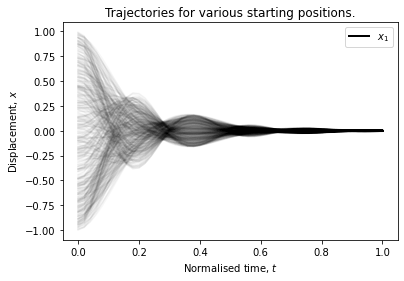

In [6]:
# dataset params
n = 500
dt, freq, samples = 0.01, 20, 50
m1 = m2 = 1
v1 = v2 = 0
c = k = 1
# x1,x2 are unspecified as they are the parameters that will vary over runs
dataset = OscillatorsDataset(n,dt,freq,samples,
                             m1=m1,m2=m2,v1=v1,v2=v2,k=k,c=c)
train_loader = DataLoader(dataset, batch_size=1)

for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='k')
plt.title('Trajectories for various starting positions.')
custom_lines = [Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['$x_1$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')
plt.show()

#### Varying $k$ only

Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k'}


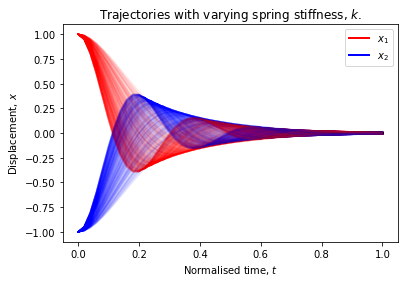

In [7]:
# dataset params
n = 500
dt, freq, samples = 0.01, 20, 50
m1 = m2 = 1
x1 = 1
x2 = -1
v1 = v2 = 0
c = 1
# x1,x2 are unspecified as they are the parameters that will vary over runs
dataset = OscillatorsDataset(n,dt,freq,samples,
                             m1=m1,m2=m2,x1=x1,x2=x2,v1=v1,v2=v2,c=c)
train_loader = DataLoader(dataset, batch_size=1)

for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Trajectories with varying spring stiffness, $k$.')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')
plt.show()

## LUPI-NDP
In the _learning under privileged information_ (LUPI) setting, we are able to provide our model with additional information during training that we hope will improve test-time performance. Conceptually, this is framed as a teacher providing some key insight to a student to help them develop a better world model than they might develop in isolation.

Practically, for NDPs I'm going to try using this information to produce better representations that the model will try to match with the context-only representation. In this way we are encouraging the model to extract the privileged information representation directly from observations. Something like

Produce a context-only representation
$$
(x_i^C,t_i^C) \rightarrow r_i^C \rightarrow r^C \\
z^C \sim \textrm{N}(\mu(r^C),\sigma(r^C)) \\
$$
produce a targets ($C\subset T$) and PI representation
$$
(x_i^T,t_i^T) \rightarrow r_i^T \rightarrow r^T \\
PI \rightarrow r^P \\
(r^P, r^T) \rightarrow r^{PT} \\
z^{PT} \sim \textrm{N}(\mu(r^{PT}),\sigma(r^{PT})) \\
$$
includes the KL term
$$
\textrm{D}_{KL}(r^{PT}||r^C)
$$
in the loss. (From this perspective we could also frame the standard training procedure for NPs, where we produce context-only and target representations, as a kind of LUPI too.)

### Code
```
Observation encoder: (x_i,t_i) ⟶ r_i
P.I. encoder: (PI) ⟶ r_p
Representation aggregator: (r_i, _) or (r_i, r_p) ⟶ r
Representation to global latent variable: r ⟶ z ~ N(mu, sigma)
Global latent sample to ODE initial condition: z' ⟶ L(t=0) = L_0
ODEfunc: (L, z, t) ⟶ dL/dt
Decoder: L(t) ⟶ x(t)
```

In [8]:
class obs_encoder(nn.Module):
    """
    Takes raw observations (x_i, t_i) and produces a representation r_i.
    """
    
    def __init__(
        self,
        obs_dim: int,
        h_dim: int,
        r_dim: int
    ):
        super(obs_encoder, self).__init__()
        
        layers = [
            nn.Linear(obs_dim+1,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, observations, times):
        return self.layers(torch.cat([observations, times.unsqueeze(-1)],-1))

In [9]:
class pi_encoder(nn.Module):
    """
    Takes the privileged information signal and produces a representation r_p.
    """
    def __init__(
        self,
        pi_dim: int,
        h_dim: int,
        r_dim: int
    ):
        super(pi_encoder, self).__init__()
        
        layers = [
            nn.Linear(pi_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [10]:
class r_aggregator(nn.Module):
    """
    Takes mixed representations from observations and privileged information and
    produces a single task representation.
    
    In evaluation mode privileged information should not be used and a warning will
    given if this is attempted.
    """
    def __init__(
        self,
        aggs: list,
        obs_r_dim: int,
        pi_r_dim: int,
        h_dim: int
    ):
        super(r_aggregator, self).__init__()
        
        self.aggs = aggs
        
        for agg in self.aggs:
            if agg not in ['mean','max','min','logsumexp']:
                raise ValueError(f'Aggregator {agg} is not supported.')
        
        # when using privileged information we combine it with a small ResNet
        layers = [
            nn.Linear(obs_r_dim*len(self.aggs)+pi_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,obs_r_dim*len(self.aggs))
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def aggregate(self, obs_r):
        # concatentate the aggregator outputs
        agg = []
        if 'max' in self.aggs:
            agg.append(torch.max(obs_r,0).values)
        if 'min' in self.aggs:
            agg.append(torch.min(obs_r,0).values)
        if 'logsumexp' in self.aggs:
            agg.append(torch.logsumexp(obs_r,0))
        if 'mean' in self.aggs:
            agg.append(torch.mean(obs_r,0))
        
        return torch.cat(agg, 0)
        
    def forward(self, r_i, r_p=None):
        if not self.training and r_p is not None:
            warnings.warn('Privileged information provided to the aggregator in evaluation mode.')
        
        # aggregate observations
        r_obs = self.aggregate(r_i)
        
        # if we have privileged information, use the resnet
        # r_obs' = r_obs + f(r_obs, r_p)
        if r_p is not None:
            r_obs = r_obs + self.layers(torch.cat([r_obs, r_p], -1))
        
        return r_obs

In [11]:
class r_to_z(nn.Module):
    """
    From task representation to global latent variable.
    """
    def __init__(
        self,
        aggregated_r_dim,
        h_dim,
        z_dim
    ):
        super(r_to_z, self).__init__()
        
        layers = [
            nn.Linear(aggregated_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU()
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
        self.h_to_mu = torch.nn.Linear(h_dim, z_dim)
        self.h_to_sigma = torch.nn.Linear(h_dim, z_dim)
        
    def forward(self, r):
        h = self.layers(r)
        mu = self.h_to_mu(h)
        sigma = 0.1 + 0.9*torch.sigmoid(self.h_to_sigma(h))
        
        return Normal(mu, sigma)

In [12]:
class z_to_L0(nn.Module):
    """
    Use a sample from the global latent variable to produce the initial L value.
    """
    def __init__(
        self,
        z_dim,
        h_dim,
        L_dim
    ):
        super(z_to_L0, self).__init__()
        
        layers = [
            nn.Linear(z_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,L_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, z_sample):
        return self.layers(z_sample)

In [13]:
class conditional_ODE_func(nn.Module):
    """
    Conditional derivative function.
    
    Input is a concatentation of the ODE latent state and the global latent variable sample,
    and the time
        (L || z, t)
    Output is the derivative at that time
        (dL || dz)
    with dz set to 0.
    
    This is a 'hacky' way to condition the ODE without letting the sample varying.
    """
    
    def __init__(
        self,
        L_dim,
        z_dim,
        h_dim
    ):
        super(conditional_ODE_func, self).__init__()
        
        layers = [
            torch.nn.Linear(L_dim+z_dim+1,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,L_dim)
        ]
        
        self.latent_func = torch.nn.Sequential(*layers)
        
        self.L_dim = L_dim
        
        self.nfe = 0
    
    def forward(self, t, L_z):
        self.nfe += 1
        z = L_z[self.L_dim:]
        L_z_t = torch.cat([L_z,t.unsqueeze(-1)])
        dL = self.latent_func(L_z_t)
        dz = torch.zeros_like(z)
        
        return torch.cat([dL,dz])

In [14]:
class decoder(nn.Module):
    """
    Produce an output from the ODE latent state and the global latent variable sample.
    """
    def __init__(
        self,
        L_dim,
        z_dim,
        h_dim,
        output_dim
    ):
        super(decoder, self).__init__()
        
        layers = [
            torch.nn.Linear(L_dim+z_dim,h_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.ReLU()
        ]
        
        self.shared_layers = torch.nn.Sequential(*layers)
        
        self.hidden_to_mu = torch.nn.Linear(h_dim, output_dim)
        self.hidden_to_sigma = torch.nn.Linear(h_dim, output_dim)
        
    def forward(self, L_z_t):
        
        hidden = self.shared_layers(L_z_t)
        mu = self.hidden_to_mu(hidden)
        sigma = 0.1 + 0.9*F.softplus(self.hidden_to_sigma(hidden))
        return Normal(mu, sigma)

In [15]:
class LUPI_NDP(nn.Module):
    
    def __init__(
        self,
        x_dim,
        obs_enc_h_dim,
        r_dim,
        pi_dim,
        pi_enc_h_dim,
        aggregators,
        agg_h_dim,
        r2z_h_dim,
        z_dim,
        z_to_L_h_dim,
        L_dim,
        ode_h_dim,
        dec_h_dim
    ):
        super(LUPI_NDP, self).__init__()
        
        task_r_dim = len(aggregators)*r_dim
        
        # note that the obs_r_dim and pi_r_dim needn't be the same
        self.observations_encoder = obs_encoder(x_dim, obs_enc_h_dim, r_dim)
        self.privileged_info_encoder = pi_encoder(pi_dim, pi_enc_h_dim, r_dim)
        self.representation_aggregator = r_aggregator(aggregators, r_dim, r_dim, agg_h_dim)
        self.representation_to_global_latent = r_to_z(task_r_dim, r2z_h_dim, z_dim)
        self.global_latent_to_initial_value = z_to_L0(z_dim, z_to_L_h_dim, L_dim)
        self.odefunc = conditional_ODE_func(L_dim, z_dim, ode_h_dim)
        self.decoder = decoder(L_dim, z_dim, dec_h_dim, x_dim)
        
    def forward(self, observations, times, p_info, context_idx, target_idx):
        if self.training:
            # encode
            r_i = self.observations_encoder(observations, times)
            r_p = self.privileged_info_encoder(p_info)
            # aggregate
            r_C = self.representation_aggregator(r_i[context_idx],None)
            r_T = self.representation_aggregator(r_i[target_idx],r_p)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            z_T = self.representation_to_global_latent(r_T)
            # sample (from target Z during training)
            z_ = z_T.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx])
            return z_C, z_T, self.decoder(L_z_t)
        
        else:
            # encode
            r_i = self.observations_encoder(observations[context_idx],
                                            times[context_idx])
            # aggregate
            r_C = self.representation_aggregator(r_i,None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            # sample (from context Z during eval.)
            z_ = z_C.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx].squeeze())
            return self.decoder(L_z_t)

#### Generate the dataset and divide into training, validation and testing splits

In [16]:
# dataset params
n = 500
dt, freq, samples = 0.01, 20, 50
m1 = m2 = 1
x1 = 1
x2 = -1
v1 = v2 = 0
c = 1
# x1,x2 are unspecified as they are the parameters that will vary over runs
dataset = OscillatorsDataset(n,dt,freq,samples,
                             m1=m1,m2=m2,x1=x1,x2=x2,v1=v1,v2=v2,c=c)
training = dataset[:int(n*0.8)]
validation = dataset[int(n*0.8):int(n*0.9)]
testing = dataset[int(n*0.9):]

train_loader = DataLoader(training, batch_size=1)
val_loader = DataLoader(validation, batch_size=1)
test_loader = DataLoader(testing, batch_size=1)

Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k'}


#### Define the model and training hyperparameters

In [17]:
x_dim = 2
obs_enc_h_dim = 11
r_dim = 18
pi_dim = 1
pi_enc_h_dim = 11
aggregators = ['logsumexp','mean']
agg_h_dim = 17
r2z_h_dim = 19
z_dim = 23
z_to_L_h_dim = 21
L_dim = 5
ode_h_dim = 13
dec_h_dim = 19

model = LUPI_NDP(x_dim, obs_enc_h_dim, r_dim,
                 pi_dim, pi_enc_h_dim,
                 aggregators, agg_h_dim,
                 r2z_h_dim, z_dim, z_to_L_h_dim,
                 L_dim, ode_h_dim, dec_h_dim).to(device)

In [18]:
learning_rate = 1e-3
epochs = 1
validate_and_print = 10
train_n = len(training)
val_n = len(validation)

context_range = range(5,10)
# target size includes context size
target_range = range(15,51)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Single pass (untrained)

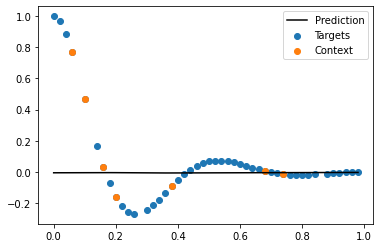

In [19]:
pi, x, times = next(iter(train_loader))
pi, x, times = pi.to(device), x.to(device), times.to(device)

context_range = range(5,10)
target_range = range(15,51)

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = random.sample(range(samples),target_size) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)


# haven't sorted out time sampled batching properly yet so squeezing out the batch dim
zC,zT,preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
plt.scatter(times.to('cpu').squeeze(0)[target_idx],x.to('cpu').squeeze(0)[target_idx][:,0], label='Targets')
plt.scatter(times.to('cpu').squeeze(0)[context_idx],x.to('cpu').squeeze(0)[context_idx][:,0], label='Context')
plt.plot(times.to('cpu').squeeze(0)[target_idx],preds.loc[:,0].to('cpu').detach(), color='k', label='Prediction')
plt.legend()
plt.show()

### Training

In [20]:
for epoch in range(epochs):
    total_epoch_loss = 0
    recon_epoch_loss = 0
    kl_epoch_loss = 0
    # training loop
    for i,batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        pi, x, times = batch
        pi, x, times = pi.to(device), x.to(device), times.to(device)
        
        # context/target idx
        context_size = random.sample(context_range,1)[0]
        target_size = random.sample(target_range,1)[0]
        # during training, context are a subset of targets
        target_idx = random.sample(range(samples),target_size)
        context_idx = random.sample(target_idx, context_size)
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx).to(device)
        context_idx = torch.LongTensor(context_idx).to(device)
        
        zC, zT, preds = model(x.squeeze(0),
                              times.squeeze(0),
                              pi.squeeze(0),
                              context_idx,
                              target_idx)

        # reconstruction term
        log_likelihood = preds.log_prob(x.squeeze(0)[target_idx]).sum()
        # kl term
        kl = kl_divergence(zT, zC).sum()
        
        loss = -log_likelihood + kl

        loss.backward()
        
        optimizer.step()
        
        total_epoch_loss += loss.item()
        recon_epoch_loss += -log_likelihood.item()
        kl_epoch_loss += kl.item()
    # validation and printing loop
    with torch.no_grad():
        if (epoch+1) % validate_and_print == 0:
            model.eval()
            val_recon = 0
            
            for i, batch in enumerate(val_loader):
                pi, x, times = batch
                pi, x, times = pi.to(device), x.to(device), times.to(device)
                
                # context/target idx
                context_size = random.sample(context_range,1)[0]
                # during eval, context and targets are disjoint and targets are all
                target_idx = random.sample(range(samples),samples)
                context_idx = random.sample(range(samples), context_size)
                target_idx = list(set(range(samples))-set(context_idx))
                context_idx.sort()
                target_idx = torch.LongTensor(target_idx)
                context_idx = torch.LongTensor(context_idx)
                
                preds = model(x.squeeze(0),times.squeeze(0),pi.squeeze(0),
                            context_idx,target_idx)
                log_likelihood = preds.log_prob(x.squeeze(0)[target_idx]).mean()
                
                val_recon += -log_likelihood.item()
            print_string = (
                "Epoch {0:d} \t"
                "Train {1:.0f} / {2:.0f} / {3:.0f} \t"
                "Val {4:.0f}"
            ).format(epoch+1,
                    total_epoch_loss/train_n, recon_epoch_loss/train_n, kl_epoch_loss/train_n,
                    val_recon/val_n)
            print(print_string)
            model.train()

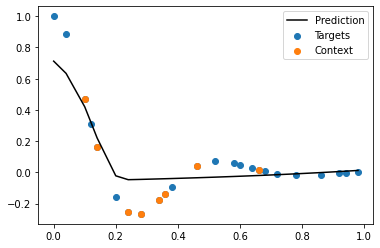

In [25]:
pi, x, times = next(iter(train_loader))
pi, x, times = pi.to(device), x.to(device), times.to(device)

context_range = range(5,10)
target_range = range(15,51)

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = random.sample(range(samples),target_size) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)


# haven't sorted out time sampled batching properly yet so squeezing out the batch dim
zC,zT,preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
plt.scatter(times.to('cpu').squeeze(0)[target_idx],x.to('cpu').squeeze(0)[target_idx][:,0], label='Targets')
plt.scatter(times.to('cpu').squeeze(0)[context_idx],x.to('cpu').squeeze(0)[context_idx][:,0], label='Context')
plt.plot(times.to('cpu').squeeze(0)[target_idx],preds.loc[:,0].to('cpu').detach(), color='k', label='Prediction')
plt.legend()
plt.show()

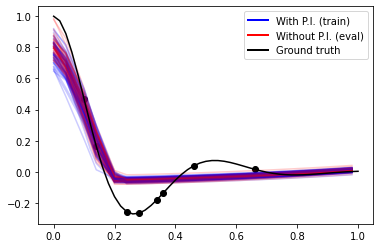

In [28]:
for _ in range(50):
    # haven't sorted out time sampled batching properly yet so squeezing out the batch dim
    model.train()
    zC,zT,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    model.eval()
    eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    plt.plot(times.to('cpu').squeeze(0)[target_idx],train_preds.loc[:,0].to('cpu').detach(), color='b', alpha=0.2)
    plt.plot(times.to('cpu').squeeze(0)[target_idx],eval_preds.loc[:,0].to('cpu').detach(), color='r', alpha=0.2)
plt.plot(times.to('cpu').squeeze(0), x.to('cpu').squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.to('cpu').squeeze(0)[context_idx],x.to('cpu').squeeze(0)[context_idx][:,0], label='Context',color='k')
plt.legend()
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['With P.I. (train)', 'Without P.I. (eval)', 'Ground truth'])
plt.show()

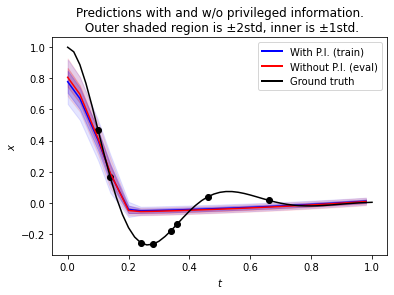

In [31]:
# sample a bunch of predictions
z_samples = 50
pi_preds = []
nopi_preds = []
for _ in range(z_samples):
    # haven't sorted out time sampled batching properly yet so squeezing out the batch dim
    model.train()
    _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    pi_preds.append(train_preds.loc[:,0].detach())
    model.eval()
    eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    nopi_preds.append(eval_preds.loc[:,0].detach())
pi_mean = torch.stack(pi_preds,0).mean(0).to('cpu')
pi_std = torch.stack(pi_preds,0).std(0).to('cpu')
eval_mean = torch.stack(nopi_preds,0).mean(0).to('cpu')
eval_std = torch.stack(nopi_preds,0).std(0).to('cpu')

# plot ±2 std and ±1 std as transparent fills
plt.fill_between(times.to('cpu').squeeze(0)[target_idx],eval_mean+2*eval_std,eval_mean-2*eval_std, alpha = 0.1, color='r')
plt.fill_between(times.to('cpu').squeeze(0)[target_idx],pi_mean+2*pi_std,pi_mean-2*pi_std, alpha = 0.1, color='b')
plt.fill_between(times.to('cpu').squeeze(0)[target_idx],eval_mean+eval_std,eval_mean-eval_std, alpha = 0.2, color='r')
plt.fill_between(times.to('cpu').squeeze(0)[target_idx],pi_mean+pi_std,pi_mean-pi_std, alpha = 0.2, color='b')
# plot means over the top
plt.plot(times.to('cpu').squeeze(0)[target_idx],pi_mean,color='b')
plt.plot(times.to('cpu').squeeze(0)[target_idx],eval_mean,color='r')
# ground truth in black with context dots
plt.plot(times.to('cpu').squeeze(0), x.to('cpu').squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.to('cpu').squeeze(0)[context_idx],x.to('cpu').squeeze(0)[context_idx][:,0], label='Context',color='k')
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['With P.I. (train)', 'Without P.I. (eval)', 'Ground truth'])
plt.title('Predictions with and w/o privileged information.\n Outer shaded region is ±2std, inner is ±1std.')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()